In [1]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs


def bokeh_plotter(data_list, x_axis_list=None, label_list=None,
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):

        color = next(color_cycle)

        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception(
                'problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i + 1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)


def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return

    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')


def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1,
                             speed_profile=True):
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values

    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x'] ** 2 + df['speed_y'] ** 2) ** 0.5

    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold

    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1, fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[
                          0] - 1  # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]

    saccade_dict = {'saccade_start_ind': saccade_on_inds,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind': saccade_off_inds,
                    'saccade_end_timestamp': saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}

    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)

    distances = []
    angles = []
    speed_list = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) &
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            speed_list.append(saccade_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                                   endpoint['center_x'] - initial_position['center_x'])

        angles.append(overall_angle)
        distances.append(distance_traveled)

    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(
        angles) % 360)  # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df[
        'initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df[
        'initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)

    return df, saccade_events_df


# create a multi-animal block_collection:

def create_block_collections(animals, block_lists, experiment_path, bad_blocks=None):
    """
    Create block collections and a block dictionary from multiple animals and their respective block lists.

    Parameters:
    - animals: list of str, names of the animals.
    - block_lists: list of lists of int, block numbers corresponding to each animal.
    - experiment_path: pathlib.Path, path to the experiment directory.
    - bad_blocks: list of int, blocks to exclude. Default is an empty list.

    Returns:
    - block_collection: list of BlockSync objects for all specified blocks.
    - block_dict: dictionary where keys are block numbers as strings and values are BlockSync objects.
    """
    import UtilityFunctions_newOE as uf

    if bad_blocks is None:
        bad_blocks = []

    block_collection = []
    block_dict = {}

    for animal, blocks in zip(animals, block_lists):
        # Generate blocks for the current animal
        current_blocks = uf.block_generator(
            block_numbers=blocks,
            experiment_path=experiment_path,
            animal=animal,
            bad_blocks=bad_blocks
        )
        # Add to collection and dictionary
        block_collection.extend(current_blocks)
        for b in current_blocks:
            block_dict[f"{animal}_block_{b.block_num}"] = b

    return block_collection, block_dict


# Example usage:
animals = ['PV_62', 'PV_126', 'PV_57']
block_lists = [[24, 26, 38], [7, 8, 9, 10, 11, 12], [7, 8, 9, 12, 13]]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
bad_blocks = [0]  # Example of bad blocks

block_collection, block_dict = create_block_collections(
    animals=animals,
    block_lists=block_lists,
    experiment_path=experiment_path,
    bad_blocks=bad_blocks
)
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    #load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later

    for block in block_collection:
        # block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_corr_angles.csv')
        # block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_corr_angles.csv')
        #block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_degrees_raw_xflipped.csv')
        #block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_degrees_raw_xflipped.csv')
        block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_degrees_raw_verified.csv')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_degrees_raw_verified.csv')
        # block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_3d_corr_verified.csv')
        # block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_3d_corr_verified.csv')
        # block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_degrees_rotated_verified.csv')
        # block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_degrees_rotated_verified.csv')

    # calibrate pupil diameter:
    # if 'pupil_diameter' not in block.left_eye_data.columns:
    #     block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax * 2 * np.pi
    #     block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax * 2 * np.pi
    #     block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
    #     block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

instantiated block number 024 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_024, new OE version
Found the sample rate for block 024 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 024
got it!
instantiated block number 026 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_026, new OE version
Found the sample rate for block 026 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 026
got it!
instantiated block number 038 at Path: Z:\Nimrod\experiments\PV_62\2023_05_01\block_038, new OE version
Found the sample rate for block 038 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 038
got it!
instantiated block number 007 at Path: Z:\Nimrod\experi

In [2]:
for block in block_collection:
  if 'pupil_diameter' not in block.left_eye_data.columns:
        print('hi')
        block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax * 2 * np.pi
        block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax * 2 * np.pi
        block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
        block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi


In [6]:
for block in block_collection:
    block.left_eye_data.drop(columns=['k_phi', 'k_theta'], inplace=True)
    block.right_eye_data.drop(columns=['k_phi', 'k_theta'], inplace=True)
    # then rename in-place
    block.left_eye_data = block.left_eye_data.rename(columns={'corr_phi': 'k_phi', 'corr_theta': 'k_theta'})
    block.right_eye_data = block.right_eye_data.rename(columns={'corr_phi': 'k_phi', 'corr_theta': 'k_theta'})

In [3]:
def create_saccade_events_with_direction_segmentation_robust(
        eye_data_df,
        speed_threshold,  # angular speed threshold in degrees/frame
        directional_delta_threshold_deg=25,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=1,
        speed_profile=True,
        min_subsaccade_samples=2,
        min_net_disp=0.5  # minimal net angular displacement (in degrees) for a segment to be valid
):
    """
    Detects and segments saccade events in eye tracking data using angular speed and directional changes.
    This robust version avoids producing segments with near-zero net displacement by:
      1. Defining the saccade onset as the first frame where the angular speed exceeds the threshold.
      2. Segmenting the event based on sustained directional changes.
      3. Discarding segments whose overall net angular displacement (computed from k_phi and k_theta)
         is below a user-specified minimal value.

    Parameters:
      - eye_data_df (pd.DataFrame): DataFrame with columns including:
            'center_x', 'center_y', 'k_phi', 'k_theta', 'OE_timestamp', 'ms_axis', 'pupil_diameter'.
      - speed_threshold (float): Angular speed threshold (degrees/frame) for detection.
      - directional_delta_threshold_deg (float): Angular change threshold to determine segmentation boundaries.
      - magnitude_calib (float): Calibration factor (not applied to angular measures).
      - speed_profile (bool): Whether to record speed profiles.
      - min_subsaccade_samples (int): Minimum number of samples required for a valid segment.
      - min_net_disp (float): Minimal net angular displacement (in degrees) required for a segment to be kept.

    Returns:
      - df (pd.DataFrame): The input DataFrame with added computed columns.
      - saccade_events_df (pd.DataFrame): DataFrame listing detected and segmented saccade events, with metrics.
    """
    # Make a copy so as not to modify the original DataFrame.
    df = eye_data_df.copy()

    ### 1. Compute Frame-to-Frame Differences
    df["speed_x"] = df["center_x"].diff()
    df["speed_y"] = df["center_y"].diff()
    df["speed_r"] = np.sqrt(df["speed_x"] ** 2 + df["speed_y"] ** 2)

    # Angular differences (k_phi and k_theta are in degrees)
    df["angular_speed_phi"] = df["k_phi"].diff()
    df["angular_speed_theta"] = df["k_theta"].diff()
    df["angular_speed_r"] = np.sqrt(df["angular_speed_phi"] ** 2 + df["angular_speed_theta"] ** 2)

    ### 2. Saccade Detection Based on Angular Speed
    # Mark frames where the instantaneous angular speed exceeds the threshold.
    df["is_saccade_angle"] = df["angular_speed_r"] > speed_threshold

    # Identify transitions to detect onsets and offsets.
    saccade_on_off = df["is_saccade_angle"].astype(int) - df["is_saccade_angle"].shift(1, fill_value=0).astype(int)
    # Use the first frame above threshold as onset
    saccade_on_inds = np.where(saccade_on_off == 1)[0]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]

    # Handle mismatches: if a saccade starts but does not end, drop the last onset.
    if len(saccade_on_inds) > len(saccade_off_inds):
        saccade_on_inds = saccade_on_inds[:-1]

    saccade_events = []

    ### 3. Process Each Detected Saccade for Segmentation
    for start_ind, end_ind in zip(saccade_on_inds, saccade_off_inds):
        saccade_df = df.iloc[start_ind:end_ind + 1].copy()
        if saccade_df.empty or len(saccade_df) < min_subsaccade_samples:
            continue

        # Compute instantaneous angles (for both pixel- and angular-based estimates)
        saccade_df["inst_angle_pixel"] = np.degrees(np.arctan2(saccade_df["speed_y"], saccade_df["speed_x"]))
        saccade_df["inst_angle_deg"] = np.degrees(
            np.arctan2(saccade_df["angular_speed_theta"], saccade_df["angular_speed_phi"]))

        # Define helper function for minimal angular difference (handling circularity)
        minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180

        angles = saccade_df["inst_angle_deg"].values
        # Compute consecutive differences
        angle_diffs = np.array([minimal_angle_diff_deg(angles[i + 1], angles[i]) for i in range(len(angles) - 1)])

        # Identify candidate segmentation boundaries when the absolute change exceeds threshold.
        candidate_boundaries = np.where(np.abs(angle_diffs) > directional_delta_threshold_deg)[0].tolist()

        # Always include the first and last frame of the saccade.
        boundaries = [0] + candidate_boundaries + [len(saccade_df) - 1]

        # Process each segment defined by these boundaries.
        for i in range(len(boundaries) - 1):
            seg_start = boundaries[i]
            seg_end = boundaries[i + 1]
            subsaccade = saccade_df.iloc[seg_start: seg_end + 1]
            if len(subsaccade) < min_subsaccade_samples:
                continue

            # Compute net angular displacement using the angular positions (k_phi and k_theta)
            initial_pos_angle = subsaccade.iloc[0][["k_phi", "k_theta"]]
            final_pos_angle = subsaccade.iloc[-1][["k_phi", "k_theta"]]
            net_disp = np.sqrt((final_pos_angle["k_phi"] - initial_pos_angle["k_phi"]) ** 2 +
                               (final_pos_angle["k_theta"] - initial_pos_angle["k_theta"]) ** 2)

            # Only record segments whose net displacement is above min_net_disp.
            if net_disp < min_net_disp:
                continue

            # Timing and indices
            sub_start_timestamp = subsaccade["OE_timestamp"].iloc[0]
            sub_end_timestamp = subsaccade["OE_timestamp"].iloc[-1]
            sub_start_ms = subsaccade["ms_axis"].iloc[0]
            sub_end_ms = subsaccade["ms_axis"].iloc[-1]
            sub_length = subsaccade.index[-1] - subsaccade.index[0]

            # Pixel-based metrics
            magnitude_raw_pixel = subsaccade["speed_r"].sum()
            magnitude_pixel = magnitude_raw_pixel * magnitude_calib

            # Angular-based metric: sum of instantaneous angular speeds
            magnitude_raw_angular = subsaccade["angular_speed_r"].sum()

            # Overall angular-based angle (from start to end)
            overall_angle_deg = (np.degrees(np.arctan2(
                final_pos_angle["k_theta"] - initial_pos_angle["k_theta"],
                final_pos_angle["k_phi"] - initial_pos_angle["k_phi"]
            )) % 360)

            # (Optional) Capture speed profiles and other details
            speed_profile_pixel = subsaccade["speed_r"].values if speed_profile else None
            speed_profile_pixel_calib = (speed_profile_pixel * magnitude_calib) if speed_profile else None
            speed_profile_angular = subsaccade["angular_speed_r"].values if speed_profile else None
            diameter_profile = subsaccade["pupil_diameter"].values

            saccade_events.append({
                "saccade_start_ind": subsaccade.index[0],
                "saccade_end_ind": subsaccade.index[-1],
                "saccade_start_timestamp": sub_start_timestamp,
                "saccade_end_timestamp": sub_end_timestamp,
                "saccade_on_ms": sub_start_ms,
                "saccade_off_ms": sub_end_ms,
                "length": sub_length,
                "magnitude_raw_pixel": magnitude_raw_pixel,
                "magnitude_pixel": magnitude_pixel,
                "magnitude_raw_angular": magnitude_raw_angular,
                "overall_angle_deg": overall_angle_deg,
                "net_angular_disp": net_disp,
                "speed_profile_pixel": speed_profile_pixel,
                "speed_profile_pixel_calib": speed_profile_pixel_calib,
                "speed_profile_angular": speed_profile_angular,
                "diameter_profile": diameter_profile,
                "theta_init_pos": initial_pos_angle["k_theta"],
                "theta_end_pos": final_pos_angle["k_theta"],
                "phi_init_pos": initial_pos_angle["k_phi"],
                "phi_end_pos": final_pos_angle["k_phi"]
            })

    # Convert the list to a DataFrame.
    saccade_events_df = pd.DataFrame(saccade_events)

    # Optionally remove intermediate column
    df.drop(["is_saccade_angle"], axis=1, inplace=True)

    # Calculate delta columns for convenience.
    if not saccade_events_df.empty:
        saccade_events_df['delta_theta'] = saccade_events_df['theta_end_pos'] - saccade_events_df['theta_init_pos']
        saccade_events_df['delta_phi'] = saccade_events_df['phi_end_pos'] - saccade_events_df['phi_init_pos']

    return df, saccade_events_df


In [19]:
bokeh_plotter([block.left_eye_data.angular_speed_r])

In [20]:

for block in block_collection:
    print(block)
    block.left_eye_data, block.l_saccade_df = create_saccade_events_with_direction_segmentation_robust(
        block.left_eye_data,
        0.6,  # angular speed threshold in degrees/frame
        directional_delta_threshold_deg=100,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=1,
        speed_profile=True,
        min_subsaccade_samples=2)
    block.right_eye_data, block.r_saccade_df = create_saccade_events_with_direction_segmentation_robust(
        block.right_eye_data,
        0.6,  # angular speed threshold in degrees/frame
        directional_delta_threshold_deg=100,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=1,
        speed_profile=True,
        min_subsaccade_samples=2)


PV_62, block 024, on 2023-04-27_11-22-56


<ipython-input-3-27a4e9125b36>:73: RuntimeWarning: invalid value encountered in double_scalars
  minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
<ipython-input-3-27a4e9125b36>:118: RuntimeWarning: invalid value encountered in double_scalars
  overall_angle_deg = (np.degrees(np.arctan2(
<ipython-input-3-27a4e9125b36>:73: RuntimeWarning: invalid value encountered in double_scalars
  minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
<ipython-input-3-27a4e9125b36>:118: RuntimeWarning: invalid value encountered in double_scalars
  overall_angle_deg = (np.degrees(np.arctan2(


PV_62, block 026, on 2023-04-27_12-21-41


<ipython-input-3-27a4e9125b36>:73: RuntimeWarning: invalid value encountered in double_scalars
  minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
<ipython-input-3-27a4e9125b36>:118: RuntimeWarning: invalid value encountered in double_scalars
  overall_angle_deg = (np.degrees(np.arctan2(
<ipython-input-3-27a4e9125b36>:73: RuntimeWarning: invalid value encountered in double_scalars
  minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
<ipython-input-3-27a4e9125b36>:118: RuntimeWarning: invalid value encountered in double_scalars
  overall_angle_deg = (np.degrees(np.arctan2(


PV_62, block 038, on 2023-05-01_13-57-45


<ipython-input-3-27a4e9125b36>:73: RuntimeWarning: invalid value encountered in double_scalars
  minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
<ipython-input-3-27a4e9125b36>:118: RuntimeWarning: invalid value encountered in double_scalars
  overall_angle_deg = (np.degrees(np.arctan2(
<ipython-input-3-27a4e9125b36>:73: RuntimeWarning: invalid value encountered in double_scalars
  minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
<ipython-input-3-27a4e9125b36>:118: RuntimeWarning: invalid value encountered in double_scalars
  overall_angle_deg = (np.degrees(np.arctan2(


PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12


<ipython-input-3-27a4e9125b36>:73: RuntimeWarning: invalid value encountered in double_scalars
  minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
<ipython-input-3-27a4e9125b36>:118: RuntimeWarning: invalid value encountered in double_scalars
  overall_angle_deg = (np.degrees(np.arctan2(
<ipython-input-3-27a4e9125b36>:73: RuntimeWarning: invalid value encountered in double_scalars
  minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
<ipython-input-3-27a4e9125b36>:118: RuntimeWarning: invalid value encountered in double_scalars
  overall_angle_deg = (np.degrees(np.arctan2(


PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41


<ipython-input-3-27a4e9125b36>:73: RuntimeWarning: invalid value encountered in double_scalars
  minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
<ipython-input-3-27a4e9125b36>:118: RuntimeWarning: invalid value encountered in double_scalars
  overall_angle_deg = (np.degrees(np.arctan2(
<ipython-input-3-27a4e9125b36>:73: RuntimeWarning: invalid value encountered in double_scalars
  minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
<ipython-input-3-27a4e9125b36>:118: RuntimeWarning: invalid value encountered in double_scalars
  overall_angle_deg = (np.degrees(np.arctan2(


PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15


<ipython-input-3-27a4e9125b36>:73: RuntimeWarning: invalid value encountered in double_scalars
  minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
<ipython-input-3-27a4e9125b36>:118: RuntimeWarning: invalid value encountered in double_scalars
  overall_angle_deg = (np.degrees(np.arctan2(
<ipython-input-3-27a4e9125b36>:73: RuntimeWarning: invalid value encountered in double_scalars
  minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
<ipython-input-3-27a4e9125b36>:118: RuntimeWarning: invalid value encountered in double_scalars
  overall_angle_deg = (np.degrees(np.arctan2(


PV_126, block 010, on PV126_Trial19_wake6_2024-07-18_15-24-57


<ipython-input-3-27a4e9125b36>:73: RuntimeWarning: invalid value encountered in double_scalars
  minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
<ipython-input-3-27a4e9125b36>:118: RuntimeWarning: invalid value encountered in double_scalars
  overall_angle_deg = (np.degrees(np.arctan2(
<ipython-input-3-27a4e9125b36>:73: RuntimeWarning: invalid value encountered in double_scalars
  minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
<ipython-input-3-27a4e9125b36>:118: RuntimeWarning: invalid value encountered in double_scalars
  overall_angle_deg = (np.degrees(np.arctan2(


PV_126, block 011, on PV126_Trial115_eyeTracking_w7


<ipython-input-3-27a4e9125b36>:73: RuntimeWarning: invalid value encountered in double_scalars
  minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
<ipython-input-3-27a4e9125b36>:118: RuntimeWarning: invalid value encountered in double_scalars
  overall_angle_deg = (np.degrees(np.arctan2(
<ipython-input-3-27a4e9125b36>:73: RuntimeWarning: invalid value encountered in double_scalars
  minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
<ipython-input-3-27a4e9125b36>:118: RuntimeWarning: invalid value encountered in double_scalars
  overall_angle_deg = (np.degrees(np.arctan2(


PV_126, block 012, on PV126_Trial116_eyeTracking_h8


<ipython-input-3-27a4e9125b36>:73: RuntimeWarning: invalid value encountered in double_scalars
  minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
<ipython-input-3-27a4e9125b36>:118: RuntimeWarning: invalid value encountered in double_scalars
  overall_angle_deg = (np.degrees(np.arctan2(
<ipython-input-3-27a4e9125b36>:73: RuntimeWarning: invalid value encountered in double_scalars
  minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
<ipython-input-3-27a4e9125b36>:118: RuntimeWarning: invalid value encountered in double_scalars
  overall_angle_deg = (np.degrees(np.arctan2(


PV_57, block 007, on pv_57_day2_03_2024-11-25_15-28-31


<ipython-input-3-27a4e9125b36>:73: RuntimeWarning: invalid value encountered in double_scalars
  minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
<ipython-input-3-27a4e9125b36>:118: RuntimeWarning: invalid value encountered in double_scalars
  overall_angle_deg = (np.degrees(np.arctan2(
<ipython-input-3-27a4e9125b36>:73: RuntimeWarning: invalid value encountered in double_scalars
  minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
<ipython-input-3-27a4e9125b36>:118: RuntimeWarning: invalid value encountered in double_scalars
  overall_angle_deg = (np.degrees(np.arctan2(


PV_57, block 008, on pv_57_day2_05_2024-11-25_16-07-18


<ipython-input-3-27a4e9125b36>:73: RuntimeWarning: invalid value encountered in double_scalars
  minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
<ipython-input-3-27a4e9125b36>:118: RuntimeWarning: invalid value encountered in double_scalars
  overall_angle_deg = (np.degrees(np.arctan2(
<ipython-input-3-27a4e9125b36>:73: RuntimeWarning: invalid value encountered in double_scalars
  minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
<ipython-input-3-27a4e9125b36>:118: RuntimeWarning: invalid value encountered in double_scalars
  overall_angle_deg = (np.degrees(np.arctan2(


PV_57, block 009, on pv_57_day2_06_2024-11-25_16-25-35


<ipython-input-3-27a4e9125b36>:73: RuntimeWarning: invalid value encountered in double_scalars
  minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
<ipython-input-3-27a4e9125b36>:118: RuntimeWarning: invalid value encountered in double_scalars
  overall_angle_deg = (np.degrees(np.arctan2(
<ipython-input-3-27a4e9125b36>:73: RuntimeWarning: invalid value encountered in double_scalars
  minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
<ipython-input-3-27a4e9125b36>:118: RuntimeWarning: invalid value encountered in double_scalars
  overall_angle_deg = (np.degrees(np.arctan2(


PV_57, block 012, on PV_57_hunter_2_2024-12-01_16-08-39


<ipython-input-3-27a4e9125b36>:73: RuntimeWarning: invalid value encountered in double_scalars
  minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
<ipython-input-3-27a4e9125b36>:118: RuntimeWarning: invalid value encountered in double_scalars
  overall_angle_deg = (np.degrees(np.arctan2(
<ipython-input-3-27a4e9125b36>:73: RuntimeWarning: invalid value encountered in double_scalars
  minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
<ipython-input-3-27a4e9125b36>:118: RuntimeWarning: invalid value encountered in double_scalars
  overall_angle_deg = (np.degrees(np.arctan2(


PV_57, block 013, on PV_57_hunter_2_2024-12-01_16-34-43


<ipython-input-3-27a4e9125b36>:73: RuntimeWarning: invalid value encountered in double_scalars
  minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
<ipython-input-3-27a4e9125b36>:118: RuntimeWarning: invalid value encountered in double_scalars
  overall_angle_deg = (np.degrees(np.arctan2(
<ipython-input-3-27a4e9125b36>:73: RuntimeWarning: invalid value encountered in double_scalars
  minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
<ipython-input-3-27a4e9125b36>:118: RuntimeWarning: invalid value encountered in double_scalars
  overall_angle_deg = (np.degrees(np.arctan2(


In [23]:
### over here, I get the lizard movements binary from mark's analysis
import os
def block_get_lizard_movement(block):
    # collect accelerometer data
    # path definition
    p = block.oe_path / 'analysis'
    analysis_list = os.listdir(p)
    correct_analysis = [i for i in analysis_list if block.animal_call in i][0]
    p = p / str(correct_analysis)
    mat_path = p / 'lizMov.mat'
    print(f'path to mat file is {mat_path}')
    # read mat file
    try:
        mat_data = h5py.File(str(mat_path), 'r')
        mat_dict = {'t_mov_ms': mat_data['t_mov_ms'][:],
                    'movAll': mat_data['movAll'][:]}

        acc_df = pd.DataFrame(data=np.array([mat_dict['t_mov_ms'][:, 0], mat_dict['movAll'][:, 0]]).T,
                              columns=['t_mov_ms', 'movAll'])
        mat_data.close()
        block.liz_mov_df = acc_df
        print(f'liz_mov_df created for {block}')
    except FileNotFoundError:
        print('mat file does not exist - run the matlab getLizMovement function')

    return


# this cell now labels the saccades as with/without head movements
def get_head_mov_col(df, mov_times):
    head_mov_bool = np.zeros(len(df), dtype=bool)  # Initialize array of False

    for i, saccade in enumerate(df.itertuples()):
        saccade_start = saccade.saccade_on_ms
        saccade_end = saccade.saccade_off_ms

        overlapping_mov_times = mov_times[np.logical_and(mov_times >= saccade_start, mov_times <= saccade_end)]

        if overlapping_mov_times.size > 0:
            head_mov_bool[i] = True

    df['head_movement'] = head_mov_bool
    return df

def label_saccade_movements(block):
    mov_times = block.liz_mov_df.t_mov_ms.values
    block.l_saccade_df = get_head_mov_col(block.l_saccade_df,mov_times=mov_times)
    block.r_saccade_df = get_head_mov_col(block.r_saccade_df,mov_times=mov_times)

# Create a list to store blocks where movement data exists
block_collection_w_mov = []

for block in block_collection:
    try:
        block_get_lizard_movement(block)  # Try loading movement data
        label_saccade_movements(block)    # Try labeling saccades

        # If both steps succeed, add block to the valid collection
        block_collection_w_mov.append(block)

    except (FileNotFoundError, OSError) as e:
        print(f"Skipping block {block}: {str(e)}")  # Notify which block failed


path to mat file is Z:\Nimrod\experiments\PV_62\2023_04_27\block_024\oe_files\2023-04-27_11-22-56\Record Node 108\analysis\recNames=Block0024,Animal=PV_62\lizMov.mat
liz_mov_df created for PV_62, block 024, on 2023-04-27_11-22-56
path to mat file is Z:\Nimrod\experiments\PV_62\2023_04_27\block_026\oe_files\2023-04-27_12-21-41\Record Node 108\analysis\recNames=Block0026,Animal=PV_62\lizMov.mat
liz_mov_df created for PV_62, block 026, on 2023-04-27_12-21-41
path to mat file is Z:\Nimrod\experiments\PV_62\2023_05_01\block_038\oe_files\2023-05-01_13-57-45\Record Node 108\analysis\recNames=Block0038,Animal=PV_62\lizMov.mat
liz_mov_df created for PV_62, block 038, on 2023-05-01_13-57-45
path to mat file is Z:\Nimrod\experiments\PV_126\2024_07_18\block_007\oe_files\PV126_Trial16_wake3_2024-07-18_12-49-12\Record Node 102\analysis\Animal=PV_126,recNames=block_007\lizMov.mat
liz_mov_df created for PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12
path to mat file is Z:\Nimrod\experim

In [24]:
# add annotations for a joint dataframe:
for block in block_collection:
    block.r_saccade_df['eye'] = 'R'
    block.r_saccade_df['block'] = block.block_num
    block.r_saccade_df['animal'] = block.animal_call
    block.l_saccade_df['eye'] = 'L'
    block.l_saccade_df['block'] = block.block_num
    block.l_saccade_df['animal'] = block.animal_call
    block.all_saccade_df = pd.concat([block.l_saccade_df,block.r_saccade_df])

In [25]:
saccade_df_list = []
for block in block_collection:
    saccade_df_list.append(block.all_saccade_df)
saccade_collection = pd.concat(saccade_df_list)

In [26]:
len(saccade_collection)

26913

In [27]:
def get_closest_diff_ind(timestamp, timeseries):
    """
    This function extracts a frame from a series so that it is as close as possible to a given timestamp
    :param timestamp: The time to match a frame to
    :param timeseries: The time frames series to look at for a match
    :param report_acc: if set to 1, will report the accuracy of the match
    :return: index_of_lowest_diff , accuracy of match (if requested)
    """
    array = np.abs(timeseries - timestamp)
    index_of_lowest_diff = np.argmin(array)
    lowest_diff_val = timeseries[index_of_lowest_diff]
    return index_of_lowest_diff, lowest_diff_val

def find_synced_saccades(df, diff_threshold=680):
    synced_saccades = []
    non_synced_saccades = []
    l_df = df.query('eye == "L"')
    r_df = df.query('eye == "R"')
    for i, row in tqdm.tqdm(l_df.iterrows()):
        l_timestamp = row['saccade_start_timestamp']
        ind_min_diff, r_timestamp = get_closest_diff_ind(l_timestamp, r_df['saccade_start_timestamp'].values)
        #print(i,ind_lowest_diff)
        time_diff = np.abs(l_timestamp - r_timestamp)
        if time_diff < diff_threshold:
            synced_saccades.append((row, r_df.iloc[ind_min_diff]))  # Collect synchronized rows
        else:
            non_synced_saccades.append(row)  # Collect non-synchronized rows
    # Create DataFrame with multi-index
    multi_index = pd.MultiIndex.from_tuples([(i, 'L') for i in range(len(synced_saccades))] + [(i, 'R') for i in range(len(synced_saccades))], names=['Main', 'Sub'])
    synced_df = pd.DataFrame(index=multi_index, columns=df.columns)
    # Populate DataFrame
    for idx, (l_row, r_row) in enumerate(synced_saccades):
        synced_df.loc[(idx, 'L')] = l_row
        synced_df.loc[(idx, 'R')] = r_row
    r_non_synced_leftovers = r_df[~r_df['saccade_start_timestamp'].isin(synced_df.query('eye == "R"')['saccade_start_timestamp'].values)]
    print(len(r_non_synced_leftovers),len(r_df))
    # Create DataFrame for non-synced saccades
    non_synced_df = pd.DataFrame(non_synced_saccades, columns=df.columns)
    non_synced_df = pd.concat([non_synced_df,r_non_synced_leftovers])

    return synced_df, non_synced_df

synced_df_list = []
non_synced_df_list = []
for saccade_df in saccade_df_list:
    # Find synced saccades:
    synced_df, non_synced_df = find_synced_saccades(saccade_df.dropna(), diff_threshold=680)
    if len(non_synced_df.dropna()) + len(synced_df.dropna()) == len(saccade_df.dropna()):
        print('got them all')

    synced_df_list.append(synced_df)
    non_synced_df_list.append(non_synced_df)


730it [00:00, 7766.07it/s]
0it [00:00, ?it/s]

310 738


706it [00:00, 2631.66it/s]
1226it [00:00, 8228.26it/s]

445 878



1454it [00:00, 7227.88it/s]

1282 1924


1468it [00:00, 7196.18it/s]
444it [00:00, 7655.07it/s]
232it [00:00, 7024.72it/s]

438 1353
324 583
337 497



296it [00:00, 7214.37it/s]
1135it [00:00, 7182.38it/s]

194 387



125it [00:00, 7336.39it/s]
454it [00:00, 4495.14it/s]

552 1293
62 145


1007it [00:00, 5472.85it/s]
1012it [00:00, 7167.68it/s]

1989 2560



827it [00:00, 7922.48it/s]

495 1152
529 947



829it [00:00, 7205.20it/s]
1059it [00:00, 6809.33it/s]


315 829
579 1282


In [28]:
def combine_synced_dataframes(dataframes):
    combined_dfs = []
    start_index = 0
    for df in dataframes:
        num_rows = len(df) // 2  # Assuming each dataframe contains pairs of rows
        main_index = pd.MultiIndex.from_tuples([(i + start_index, 'L') for i in range(num_rows)] + [(i + start_index, 'R') for i in range(num_rows)], names=['Main', 'Sub'])
        df.index = main_index
        combined_dfs.append(df)
        start_index += num_rows
    combined_df = pd.concat(combined_dfs)
    combined_df.reset_index(inplace=True)
    return combined_df

synced_saccade_collection = combine_synced_dataframes(synced_df_list)
non_synced_saccade_collection = pd.concat(non_synced_df_list)


In [29]:
all_saccade_collection = pd.concat([synced_saccade_collection,non_synced_saccade_collection])


In [23]:
import os
import pathlib
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle

def create_saccade_polar_histogram(saccade_collection, figure_size=(4,3),export_path=None):
    # Extract saccade angles for both eyes
    saccade_angles_r = saccade_collection.query('eye == "R"')['overall_angle_deg']
    saccade_angles_l = saccade_collection.query('eye == "L"')['overall_angle_deg']

    font_size = 10
    num_bins = 36

    # Compute histograms and bin centers
    hist_r, bin_edges_r = np.histogram(saccade_angles_r, bins=num_bins, range=(0, 360))
    bin_centers_r = (bin_edges_r[:-1] + bin_edges_r[1:]) / 2

    hist_l, bin_edges_l = np.histogram(saccade_angles_l, bins=num_bins, range=(0, 360))
    bin_centers_l = (bin_edges_l[:-1] + bin_edges_l[1:]) / 2

    # Calculate maximum radial value for consistent scaling
    max_count = max(hist_r.max(), hist_l.max())

    fig, axs = plt.subplots(1, 2, figsize=figure_size, dpi=150, subplot_kw=dict(projection='polar'))

    # Iterate over eyes and plot histograms
    for ax, saccade_angles, bin_centers, hist, title in zip(
            axs,
            [saccade_angles_r, saccade_angles_l],
            [bin_centers_r, bin_centers_l],
            [hist_r, hist_l],
            [f'Right Eye - {len(saccade_angles_r)}', f'Left Eye - {len(saccade_angles_l)}']
        ):

        # Plot histogram bars
        ax.bar(
            np.deg2rad(list(bin_centers.astype(int))),
            hist,
            width=np.deg2rad(360 / num_bins),
            align='center',
            color='black',
            edgecolor='black'
        )

        # Set maximum radial value for comparison
        ax.set_ylim(0, max_count)

        # Add radial gridlines
        radial_steps = np.linspace(0, max_count, 5)[1:]
        for step in radial_steps:
            ax.plot(np.linspace(0, 2*np.pi, 100), [step]*100, linestyle='dotted', color='gray', lw=0.7)
            ax.text(
                np.pi/2, step, f'{int(step)}',
                color='gray', fontsize=font_size-2,
                ha='center', va='bottom'
            )

        ax.grid(False)
        ax.tick_params(axis='both', labelsize=font_size-2)
        ax.set_yticks([])
        #ax.set_title(title, y=1.1, fontsize=font_size)

    plt.tight_layout()

    # Save the figure and pickle file if export_path is provided
    if export_path:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
        export_dir = pathlib.Path(export_path) / f'{timestamp}_Saccade_Histogram'
        export_dir.mkdir(parents=True, exist_ok=True)

        # Save PDF
        export_file_pdf = export_dir / f'{timestamp}_saccade_angles_histogram.pdf'
        plt.savefig(export_file_pdf, format='pdf')
        print(f"Exported histogram to {export_file_pdf}")

        # Save Pickle
        export_file_pkl = export_dir / f'{timestamp}_saccade_angles_data.pkl'
        with open(export_file_pkl, 'wb') as pkl_file:
            pickle.dump(saccade_collection, pkl_file)
        print(f"Exported data to {export_file_pkl}")

    plt.show()


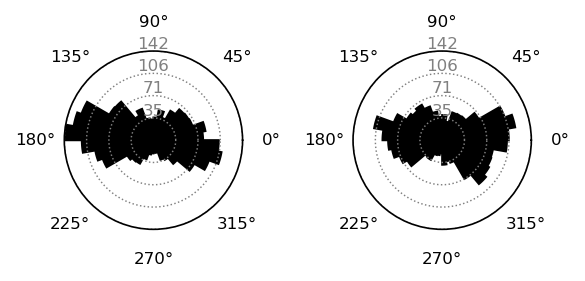

In [64]:
create_saccade_polar_histogram(synced_saccade_collection, (4,3),export_path=None)

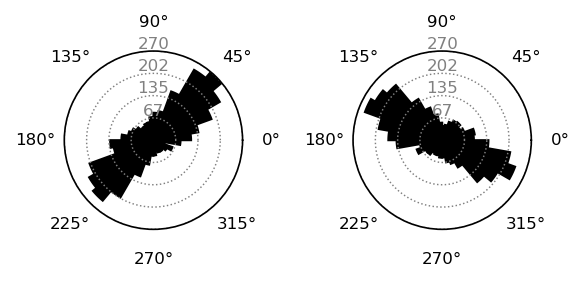

In [21]:
#tearducts corrected, degree-based
create_saccade_polar_histogram(synced_saccade_collection, (4,3),export_path=None)

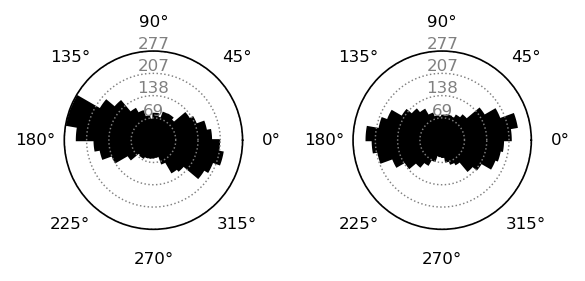

In [53]:
#3d corrected data threshold = 1:
create_saccade_polar_histogram(synced_saccade_collection, (4,3),export_path=None)

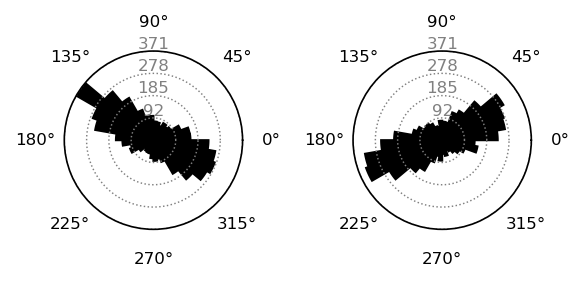

In [33]:
# raw verified data, no rotation
create_saccade_polar_histogram(synced_saccade_collection, (4,3),export_path=None)

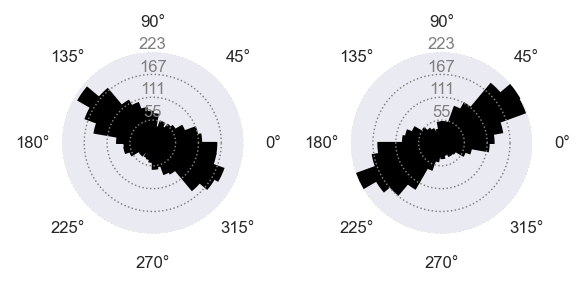

In [26]:
create_saccade_polar_histogram(synced_saccade_collection, (4,3),export_path=None)

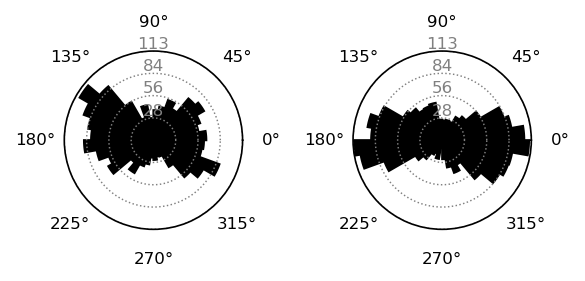

In [15]:
create_saccade_polar_histogram(synced_saccade_collection, (4,3),export_path=None)

In [35]:
import os
import pathlib
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle

def create_saccade_polar_histogram_multianimal(saccade_collection, figure_size=(8, 4), export_path=None):
    # Extract unique animals
    animals = saccade_collection['animal'].unique()
    num_bins = 36

    # Set up the polar plots
    fig, axs = plt.subplots(1, 2, figsize=figure_size, dpi=150, subplot_kw=dict(projection='polar'))
    colors = plt.cm.viridis(np.linspace(0, 1, len(animals)))  # Unique colors for each animal

    # Iterate through each animal
    for color, animal in zip(colors, animals):
        # Filter saccades for the current animal
        animal_saccades = saccade_collection.query('animal == @animal')

        # Process right eye
        saccade_angles_r = animal_saccades.query('eye == "R"')['overall_angle_deg']
        hist_r, bin_edges_r = np.histogram(saccade_angles_r, bins=num_bins, range=(0, 360), density=True)
        bin_centers_r = list(np.array((bin_edges_r[:-1] + bin_edges_r[1:]) / 2).astype(int))
        axs[0].plot(
            np.deg2rad(bin_centers_r), hist_r,
            label=f'{animal} ({len(saccade_angles_r)} saccades)',
            color=color
        )

        # Process left eye
        saccade_angles_l = animal_saccades.query('eye == "L"')['overall_angle_deg']
        hist_l, bin_edges_l = np.histogram(saccade_angles_l, bins=num_bins, range=(0, 360), density=True)
        bin_centers_l = list(np.array((bin_edges_l[:-1] + bin_edges_l[1:]) / 2).astype(int))
        print(bin_centers_l)
        axs[1].plot(
            np.deg2rad(bin_centers_l), hist_l,
            label=f'{animal} ({len(saccade_angles_l)} saccades)',
            color=color
        )

    # Format plots
    for ax, title in zip(axs, ['Right Eye', 'Left Eye']):
        ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), fontsize=6)
        #ax.set_title(f'{title} Saccades', va='bottom')
        ax.grid(False)

        ax.set_yticks([])

    plt.tight_layout()

    # Save the figure if export_path is provided
    if export_path:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
        export_dir = pathlib.Path(export_path) / f'{timestamp}_MultiAnimal_Saccade_Histogram'
        export_dir.mkdir(parents=True, exist_ok=True)

        # Save PDF
        export_file_pdf = export_dir / f'{timestamp}_saccade_angles_histogram.pdf'
        plt.savefig(export_file_pdf, format='pdf')
        print(f"Exported histogram to {export_file_pdf}")

        # Save Pickle
        export_file_pkl = export_dir / f'{timestamp}_saccade_angles_data.pkl'
        with open(export_file_pkl, 'wb') as pkl_file:
            pickle.dump(saccade_collection, pkl_file)
        print(f"Exported data to {export_file_pkl}")

    plt.show()


In [30]:
import pathlib
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle

def create_saccade_polar_histogram_multianimal(saccade_collection,
                                               figure_size=(8, 4),
                                               export_path=None):
    animals = saccade_collection['animal'].unique()
    num_bins = 36

    fig, axs = plt.subplots(1, 2,
                            figsize=figure_size, dpi=300,
                            subplot_kw=dict(projection='polar'))
    colors = plt.cm.viridis(np.linspace(0, 1, len(animals)))

    for color, animal in zip(colors, animals):
        df_animal = saccade_collection.query('animal == @animal')

        # --- Right eye ---
        angles_r = df_animal.query('eye == "R"')['overall_angle_deg']
        hist_r, edges_r = np.histogram(angles_r,
                                       bins=num_bins,
                                       range=(0, 360),
                                       density=True)

        # compute mid‐bin centers as a float64 array
        centers_r = (edges_r[:-1] + edges_r[1:]) / 2.0
        centers_r = np.asarray(centers_r, dtype=float)

        # manual deg→rad
        theta_r = centers_r * (np.pi / 180.0)

        # close the loop
        theta_r = np.concatenate([theta_r, theta_r[:1]])
        hist_r   = np.concatenate([hist_r,   hist_r[:1]])

        axs[0].plot(theta_r, hist_r,
                    label=f"{animal} ({len(angles_r)})",
                    color=color)

        # --- Left eye (same) ---
        angles_l = df_animal.query('eye == "L"')['overall_angle_deg']
        hist_l, edges_l = np.histogram(angles_l,
                                       bins=num_bins,
                                       range=(0, 360),
                                       density=True)

        centers_l = (edges_l[:-1] + edges_l[1:]) / 2.0
        centers_l = np.asarray(centers_l, dtype=float)
        theta_l   = centers_l * (np.pi / 180.0)

        theta_l = np.concatenate([theta_l, theta_l[:1]])
        hist_l  = np.concatenate([hist_l,  hist_l[:1]])

        axs[1].plot(theta_l, hist_l,
                    label=f"{animal} ({len(angles_l)})",
                    color=color)
    # Add a shaded area for probability = 0.005 in both subplots.
    for ax in axs:
        theta = np.linspace(0, 2 * np.pi, 500)
        ax.fill_between(theta, 0, 0.005, color='gray', alpha=0.2, zorder=0, label='0.005 Prob.')

    # format
    for ax in axs:
        ax.legend(loc='upper right',
                  bbox_to_anchor=(1.2, 1.1),
                  fontsize=6)
        ax.set_yticks([])
        ax.grid(False)

    plt.tight_layout()

    if export_path:
        ts = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
        outdir = pathlib.Path(export_path) / f"{ts}_MultiAnimal_Saccade_Histogram"
        outdir.mkdir(parents=True, exist_ok=True)

        pdf = outdir / f"{ts}_saccade_angles_histogram.pdf"
        plt.savefig(pdf)
        print("Exported histogram to", pdf)

        pkl = outdir / f"{ts}_saccade_angles_data.pkl"
        with open(pkl, 'wb') as f:
            pickle.dump(saccade_collection, f)
        print("Exported data to", pkl)

    plt.show()


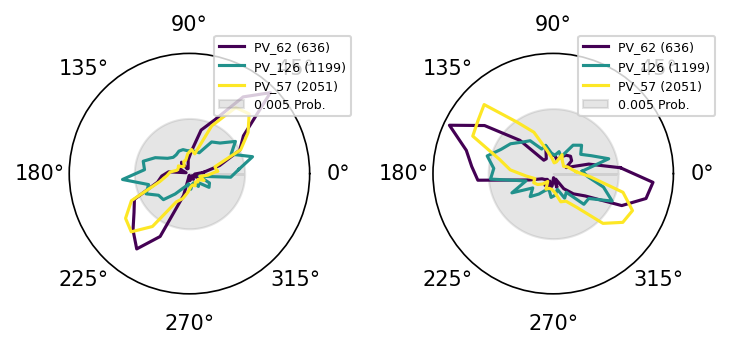

In [23]:
# tearducts corrected, degree based, thr=2
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal_degrees'
create_saccade_polar_histogram_multianimal(synced_saccade_collection, (5,4),export_path=None)

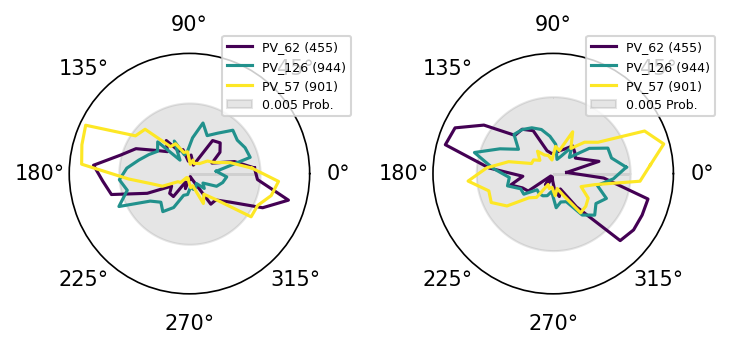

In [65]:
# 3D corrected, degree based, thr=2
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal_degrees'
create_saccade_polar_histogram_multianimal(synced_saccade_collection, (5,4),export_path=None)

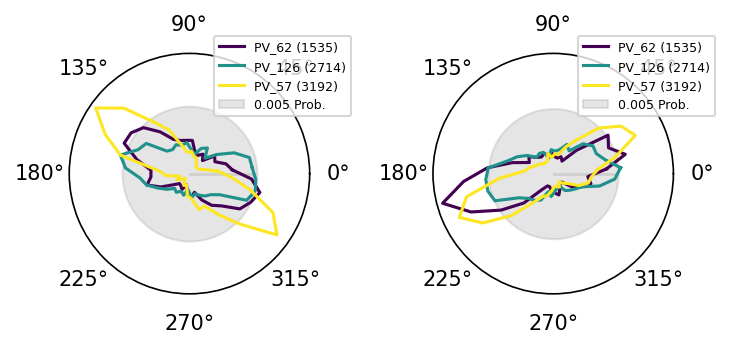

In [33]:
# thr=0.6 deg/frame
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal_degrees'
create_saccade_polar_histogram_multianimal(synced_saccade_collection, (5,4),export_path=None)

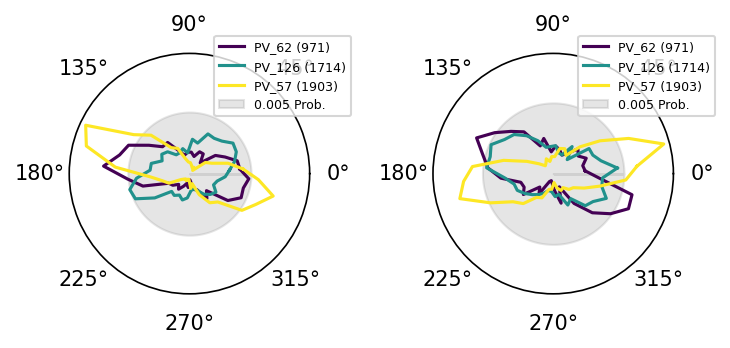

In [55]:
# 3D corrected, degree based, thr=1
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal_degrees'
create_saccade_polar_histogram_multianimal(synced_saccade_collection, (5,4),export_path=None)

Exported histogram to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal_degrees\2025_06_07_22_10_MultiAnimal_Saccade_Histogram\2025_06_07_22_10_saccade_angles_histogram.pdf
Exported data to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal_degrees\2025_06_07_22_10_MultiAnimal_Saccade_Histogram\2025_06_07_22_10_saccade_angles_data.pkl


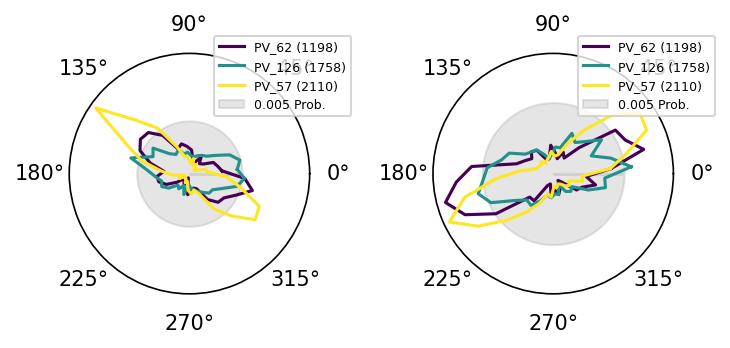

In [37]:
# raw verified degrees-based
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal_degrees'
create_saccade_polar_histogram_multianimal(synced_saccade_collection, (5,4),export_path=export_path)

Exported histogram to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal\2025_05_28_13_33_MultiAnimal_Saccade_Histogram\2025_05_28_13_33_saccade_angles_histogram.pdf
Exported data to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal\2025_05_28_13_33_MultiAnimal_Saccade_Histogram\2025_05_28_13_33_saccade_angles_data.pkl


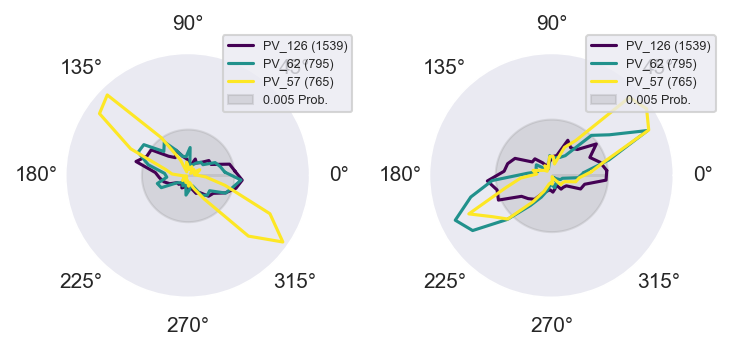

In [38]:
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal'

create_saccade_polar_histogram_multianimal(synced_saccade_collection.query('not (animal=="PV_62" and block=="023")'), (5,4),export_path=export_path)

Exported histogram to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\non_synced_saccade_polar_multi_animal\2025_05_28_13_53_MultiAnimal_Saccade_Histogram\2025_05_28_13_53_saccade_angles_histogram.pdf
Exported data to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\non_synced_saccade_polar_multi_animal\2025_05_28_13_53_MultiAnimal_Saccade_Histogram\2025_05_28_13_53_saccade_angles_data.pkl


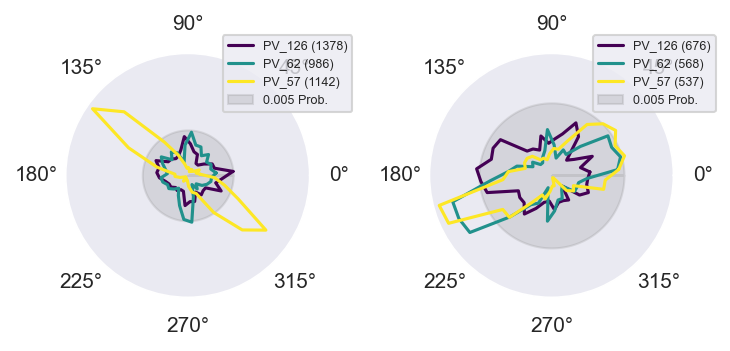

In [39]:
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\non_synced_saccade_polar_multi_animal'
create_saccade_polar_histogram_multianimal(non_synced_saccade_collection.query('not (animal=="PV_62" and block=="023")'), (5,4),export_path=export_path)

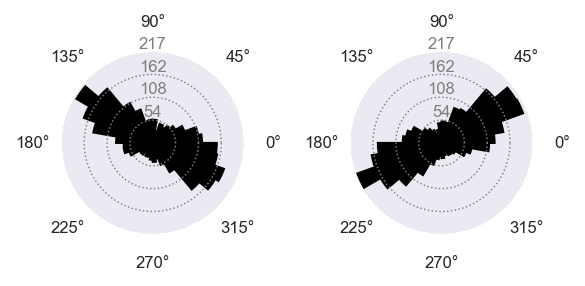

In [32]:
create_saccade_polar_histogram(synced_saccade_collection.query('not (animal=="PV_62" and block=="023")', (4,3),export_path=None)

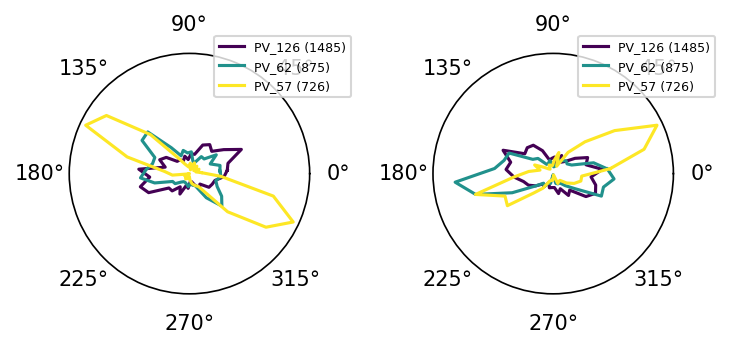

In [52]:
create_saccade_polar_histogram_multianimal(synced_saccade_collection, (5,4),export_path=None)

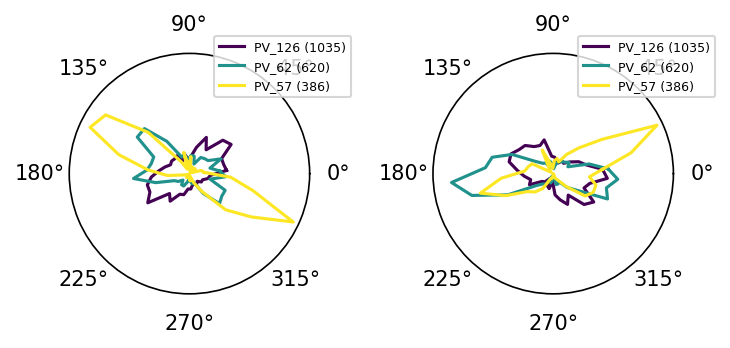

In [24]:
create_saccade_polar_histogram_multianimal(synced_saccade_collection, (5,4),export_path=None)

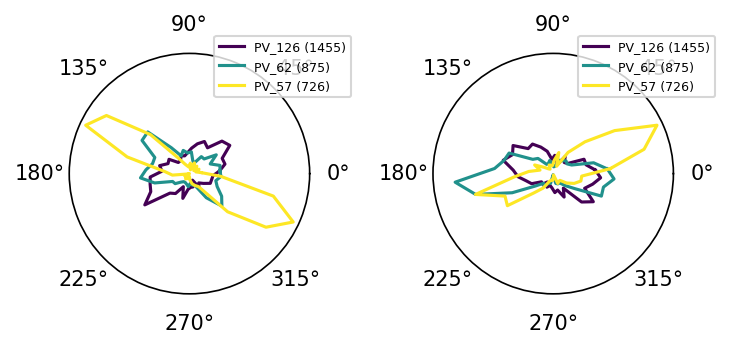

In [147]:
create_saccade_polar_histogram_multianimal(synced_saccade_collection, (5,4),export_path=None)

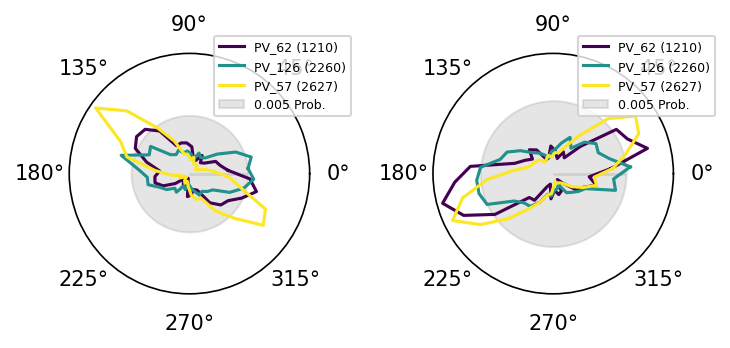

In [13]:

create_saccade_polar_histogram_multianimal(synced_saccade_collection, (5,4),export_path=None)

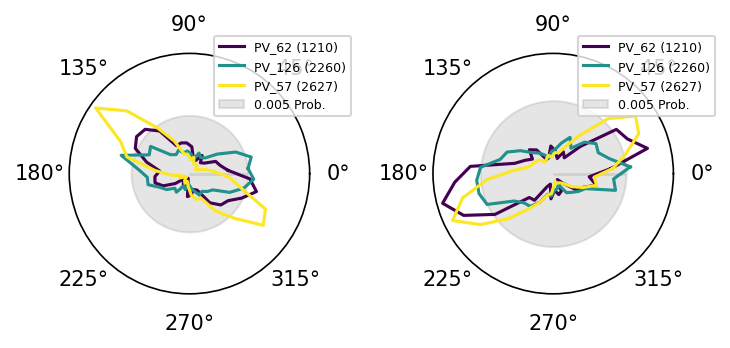

In [17]:
create_saccade_polar_histogram_multianimal(synced_saccade_collection, (5,4),export_path=None)

In [14]:
def create_saccade_polar_histogram_blockwise_per_animal(saccade_collection,
                                                         figure_size_per_block=(6, 2.5),
                                                         export_path=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import pathlib
    import datetime

    num_bins = 36
    animals = saccade_collection['animal'].unique()

    for animal in animals:
        df_animal = saccade_collection.query('animal == @animal')
        blocks = sorted(df_animal['block'].unique())
        n_blocks = len(blocks)

        fig_height = figure_size_per_block[1] * n_blocks
        fig, axs = plt.subplots(n_blocks, 2,
                                figsize=(figure_size_per_block[0], fig_height),
                                dpi=150,
                                subplot_kw=dict(projection='polar'),
                                constrained_layout=True)

        fig.suptitle(f"Animal: {animal}", fontsize=14, y=1.01)

        for block_idx, block in enumerate(blocks):
            df_block = df_animal.query('block == @block')

            # Assign: Left eye to RIGHT plot, Right eye to LEFT plot
            eye_map = {'R': 0, 'L': 1}

            for eye, col_idx in eye_map.items():
                ax = axs[block_idx][col_idx]
                angles = df_block.query('eye == @eye')['overall_angle_deg']

                hist, edges = np.histogram(angles,
                                           bins=num_bins,
                                           range=(0, 360),
                                           density=True)

                centers = (edges[:-1] + edges[1:]) / 2.0
                theta = centers * (np.pi / 180.0)

                theta = np.concatenate([theta, theta[:1]])
                hist = np.concatenate([hist, hist[:1]])

                ax.plot(theta, hist,
                        color='tab:orange' if eye == 'R' else 'tab:blue',
                        label=f"{eye} eye ({len(angles)} saccades)")
                ax.set_title(f"Block {block} - {eye} eye", fontsize=8, pad=20)
                ax.set_yticks([])
                ax.grid(False)
                ax.fill_between(np.linspace(0, 2*np.pi, 500), 0, 0.005,
                                color='gray', alpha=0.2, zorder=0)
                ax.legend(loc='upper right', fontsize=6)

        if export_path:
            ts = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
            outdir = pathlib.Path(export_path)
            outdir.mkdir(parents=True, exist_ok=True)

            pdf_path = outdir / f"{ts}_{animal}_Blockwise_Saccade_Histogram.pdf"
            plt.savefig(pdf_path, bbox_inches='tight')
            print(f"Exported: {pdf_path}")
        plt.show()


Exported: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\blockwise_per_animal_degree_histogram_no_correction\2025_06_09_15_56_PV_62_Blockwise_Saccade_Histogram.pdf


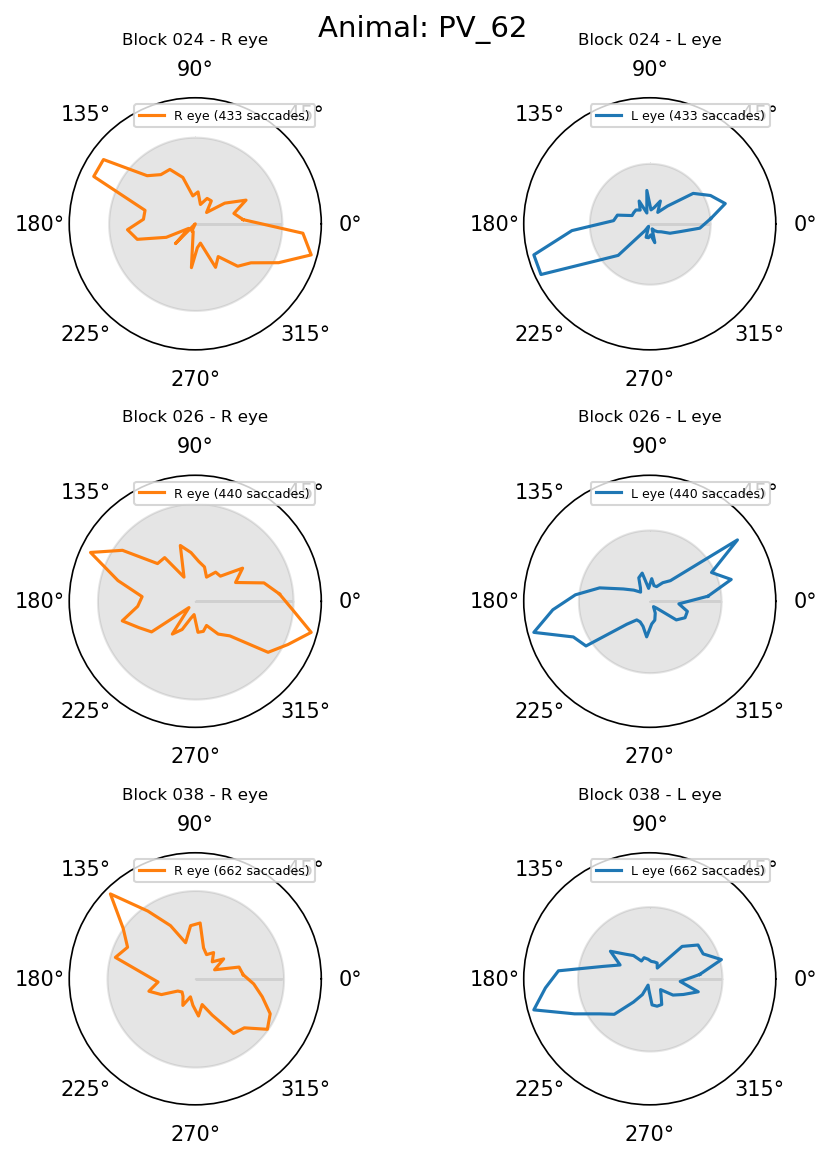

Exported: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\blockwise_per_animal_degree_histogram_no_correction\2025_06_09_15_56_PV_126_Blockwise_Saccade_Histogram.pdf


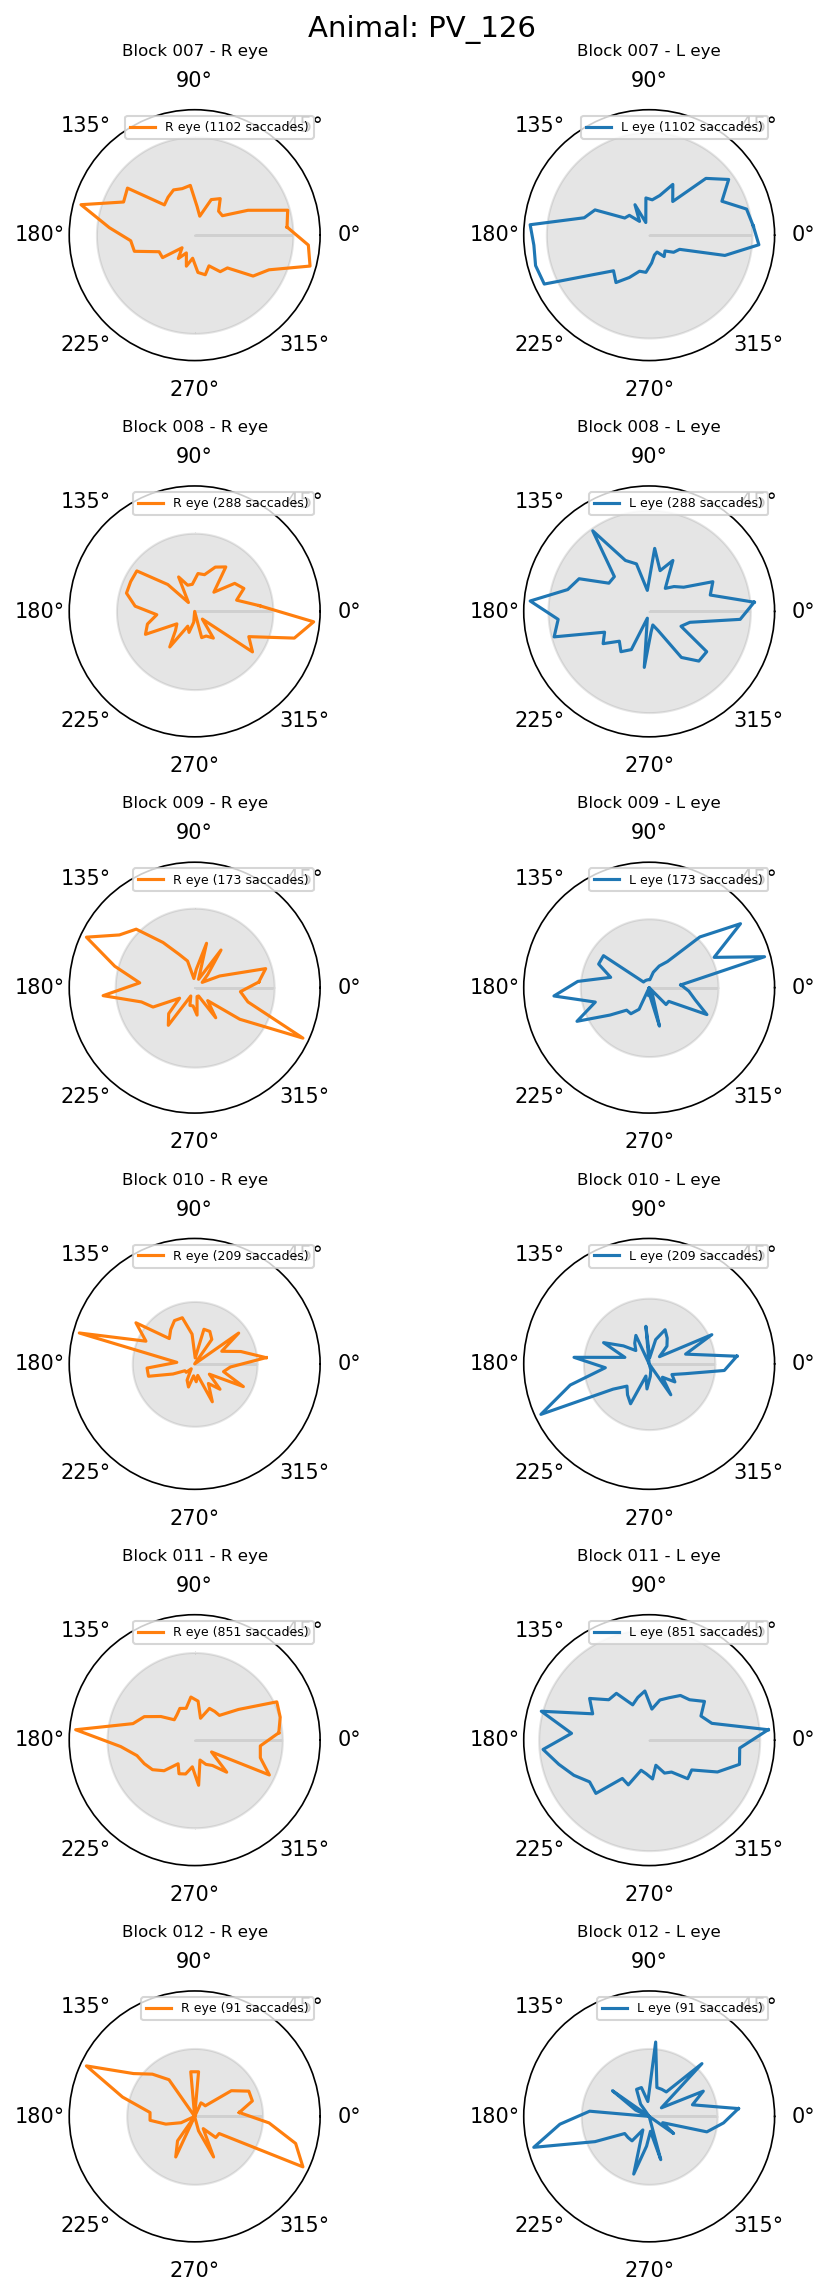

Exported: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\blockwise_per_animal_degree_histogram_no_correction\2025_06_09_15_56_PV_57_Blockwise_Saccade_Histogram.pdf


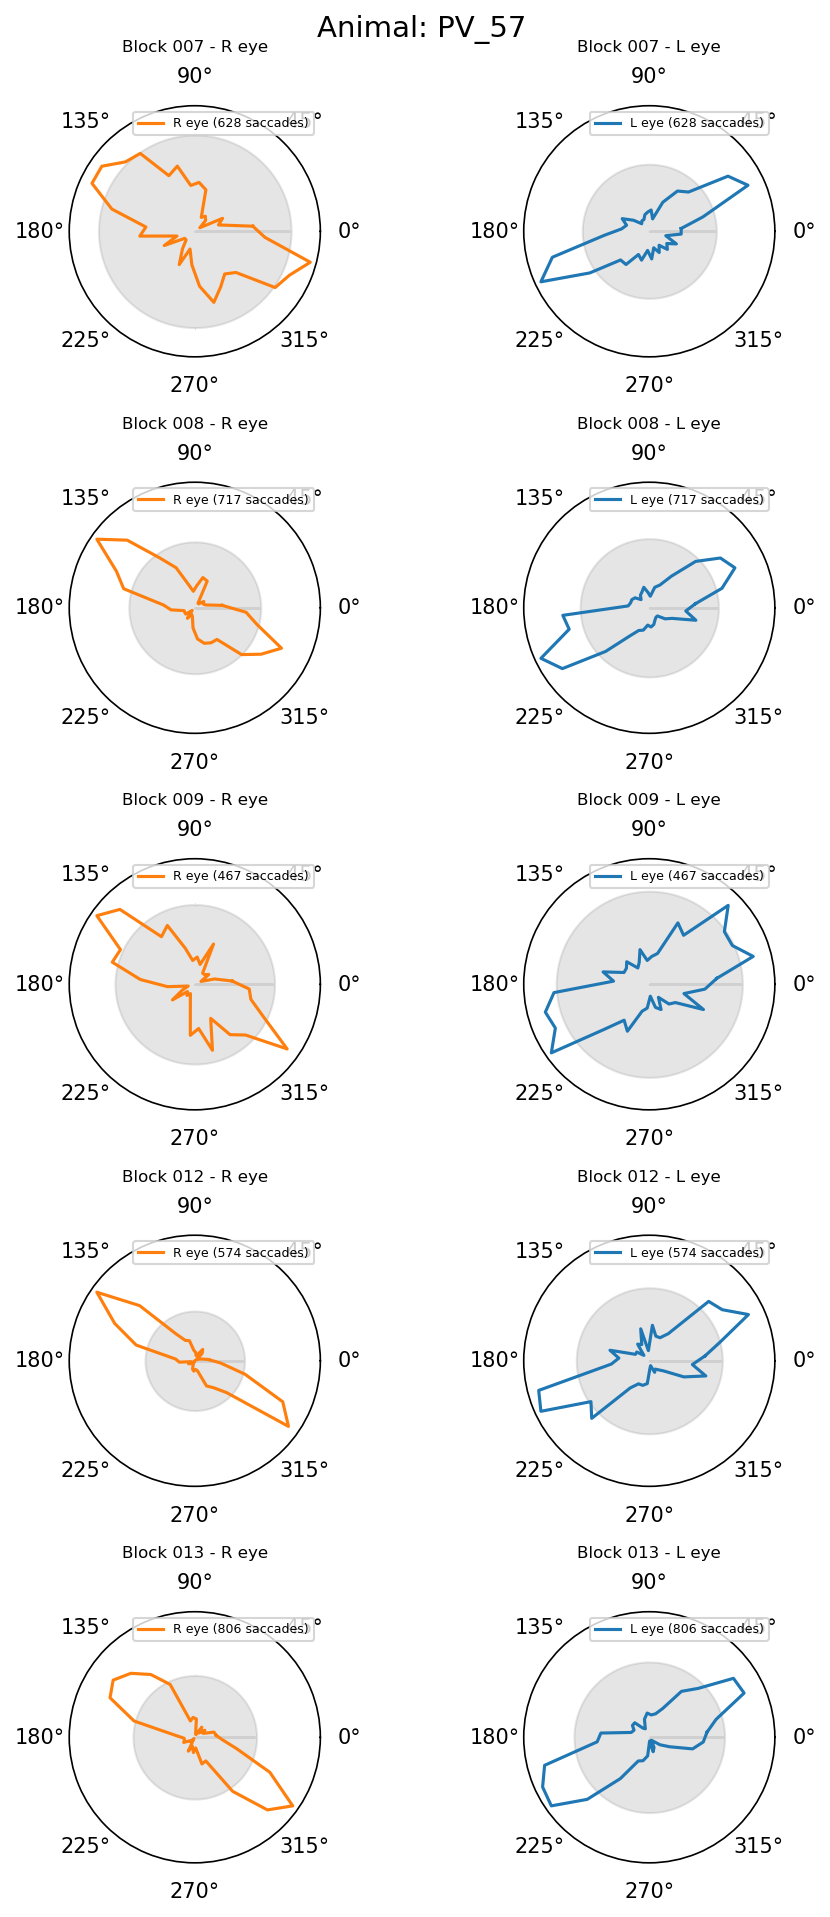

In [32]:
create_saccade_polar_histogram_blockwise_per_animal(synced_saccade_collection, export_path=r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\blockwise_per_animal_degree_histogram_no_correction')


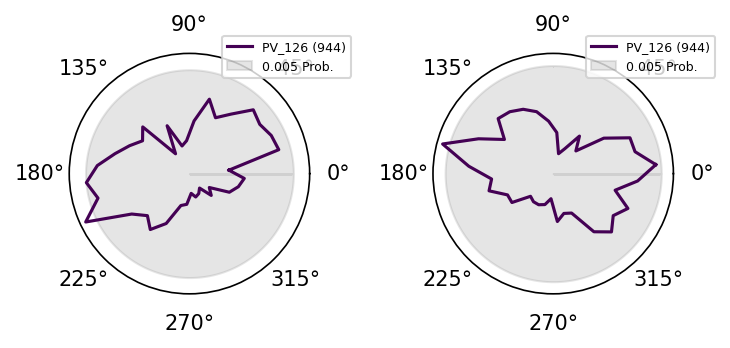

In [69]:
def create_saccade_polar_histogram_blockwise_per_animal(saccade_collection,
                                                         figure_size_per_block=(6, 2.5),
                                                         export_path=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import pathlib
    import datetime

    num_bins = 36
    animals = saccade_collection['animal'].unique()

    for animal in animals:
        df_animal = saccade_collection.query('animal == @animal')
        blocks = sorted(df_animal['block'].unique())
        n_blocks = len(blocks)

        fig_height = figure_size_per_block[1] * n_blocks
        fig, axs = plt.subplots(n_blocks, 2,
                                figsize=(figure_size_per_block[0], fig_height),
                                dpi=150,
                                subplot_kw=dict(projection='polar'),
                                squeeze=False)

        fig.suptitle(f"Animal: {animal}", fontsize=14, y=1.02)

        for block_idx, block in enumerate(blocks):
            df_block = df_animal.query('block == @block')

            for col_idx, eye in enumerate(['L', 'R']):
                ax = axs[block_idx][col_idx]
                angles = df_block.query('eye == @eye')['overall_angle_deg']

                hist, edges = np.histogram(angles,
                                           bins=num_bins,
                                           range=(0, 360),
                                           density=True)

                centers = (edges[:-1] + edges[1:]) / 2.0
                theta = centers * (np.pi / 180.0)

                # Close the loop
                theta = np.concatenate([theta, theta[:1]])
                hist = np.concatenate([hist, hist[:1]])

                ax.plot(theta, hist, color='tab:blue' if eye == 'L' else 'tab:orange',
                        label=f"{eye} eye ({len(angles)} saccades)")
                ax.set_title(f"Block {block} - {eye} eye", fontsize=8)
                ax.set_yticks([])
                ax.grid(False)
                ax.fill_between(np.linspace(0, 2*np.pi, 500), 0, 0.005,
                                color='gray', alpha=0.2, zorder=0)

                ax.legend(loc='upper right', fontsize=6)

        plt.tight_layout(h_pad=2)

        if export_path:
            ts = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
            outdir = pathlib.Path(export_path)
            outdir.mkdir(parents=True, exist_ok=True)

            pdf_path = outdir / f"{ts}_{animal}_Blockwise_Saccade_Histogram.pdf"
            plt.savefig(pdf_path)
            print(f"Exported: {pdf_path}")

        plt.show()
create_saccade_polar_histogram_multianimal(synced_saccade_collection.query("animal=='PV_126'"), (5,4),export_path=None)

<ipython-input-64-c5d87d4dff4a>:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\MarkS3\PycharmProjects\pythonProject3\venv\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MarkS3\PycharmProjects\pythonProject3\venv\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8208 missing from current font.
  font.set_text(s, 0, flags=flags)


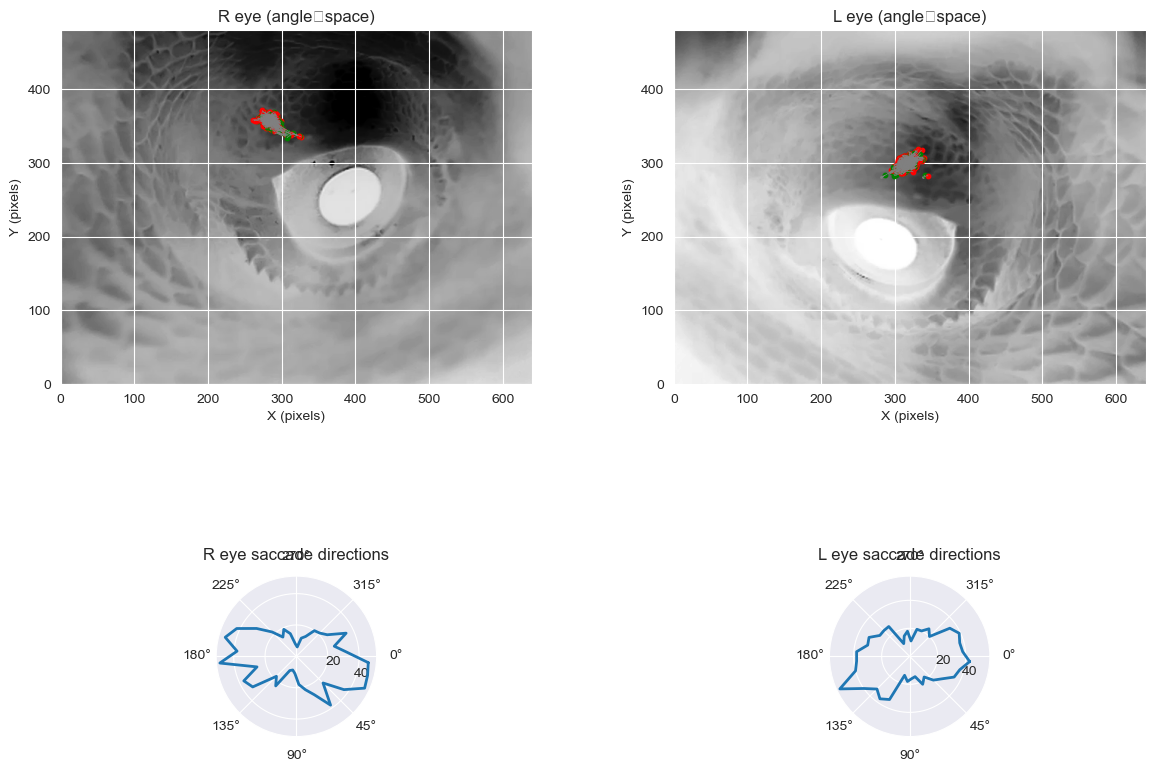

In [64]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

def plot_block_angle_saccades_with_histogram(block,
                                             all_saccade_collection,
                                             nbins=36):
    """
    Overlay angle‐space saccade traces on each eye’s image, plus a per‐eye
    polar line‐histogram of saccade directions (from the 'angle' column).

    Layout (2×2 grid):
      ┌────────────────────────┬────────────────────────┐
      │ R eye image + traces  │ L eye image + traces  │  ← height ratio = 3
      ├────────────────────────┼────────────────────────┤
      │ R eye direction hist. │ L eye direction hist. │  ← height ratio = 1
      └────────────────────────┴────────────────────────┘

    Parameters
    ----------
    block : BlockSync
        Must have:
          • .block_num, .animal_call
          • .re_videos[0], .le_videos[0]
          • .right_eye_data, .left_eye_data with 'k_phi','k_theta'
          • .kerr_ref_r_x/.kerr_ref_r_y and .kerr_ref_l_x/.kerr_ref_l_y
    all_saccade_collection : pd.DataFrame
        Must contain columns ['block','animal','eye','saccade_start_ind',
        'saccade_end_ind','angle', …].
    nbins : int
        Number of angular bins for the polar histograms.
    """
    # 1) filter to this block + drop NaNs
    mask = (
        (all_saccade_collection.block  == block.block_num) &
        (all_saccade_collection.animal == block.animal_call)
    )
    block_sacs = all_saccade_collection.loc[mask].dropna(subset=['overall_angle_deg'])

    # 2) separate direction‐angles by eye & convert to radians
    angles_r = block_sacs.loc[block_sacs.eye=='R','overall_angle_deg'] * (math.pi/180.0)
    angles_l = block_sacs.loc[block_sacs.eye=='L','overall_angle_deg'] * (math.pi/180.0)

    # 3) build 2×2 figure with custom height ratios
    fig = plt.figure(figsize=(14, 10))
    gs  = fig.add_gridspec(
        2, 2,
        height_ratios=[3, 1],
        width_ratios=[1, 1],
        hspace=0.4, wspace=0.3
    )
    ax_img_r = fig.add_subplot(gs[0,0])
    ax_img_l = fig.add_subplot(gs[0,1])
    ax_pol_r = fig.add_subplot(gs[1,0], projection='polar')
    ax_pol_l = fig.add_subplot(gs[1,1], projection='polar')

    def draw_angle_overlay(ax, eye_label, video_path, eye_df,
                           ref_x, ref_y):
        # load first frame
        cap = cv2.VideoCapture(str(video_path))
        ret, frame = cap.read()
        cap.release()
        if not ret:
            raise RuntimeError(f"Cannot read {video_path}")

        # true grayscale + invert
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        img  = 255 - gray
        h, w = img.shape

        ax.imshow(img,
                  cmap='gray', vmin=0, vmax=255,
                  extent=[0, w, 0, h],
                  origin='lower')
        ax.set_xlim(0, w); ax.set_ylim(0, h)
        ax.set_title(f"{eye_label} eye (angle‐space)")
        ax.set_xlabel("X (pixels)"); ax.set_ylabel("Y (pixels)")

        sacs = block_sacs.query('eye == @eye_label')
        for _, sac in sacs.iterrows():
            si, ei = int(sac.saccade_start_ind), int(sac.saccade_end_ind)
            seg = eye_df.iloc[si:ei+1]

            # map k_phi/k_theta → image‐centered coords
            phis   = seg['k_phi'].values
            thetas = seg['k_theta'].values
            xs = ref_x + phis
            ys = ref_y + thetas

            ax.plot(xs, ys, color='gray', linewidth=0.5)
            if len(xs) > 2:
                ax.scatter(xs[1:-1], ys[1:-1], s=1, color='gray')
            ax.scatter(xs[0],  ys[0],  s=10, color='green', label='_nolegend_')
            ax.scatter(xs[-1], ys[-1], s=10, color='red',   label='_nolegend_')

    # 4) draw overlays
    draw_angle_overlay(
        ax_img_r, 'R',
        block.re_videos[0],
        block.right_eye_data,
        block.kerr_ref_r_x, block.kerr_ref_r_y
    )
    draw_angle_overlay(
        ax_img_l, 'L',
        block.le_videos[0],
        block.left_eye_data,
        block.kerr_ref_l_x, block.kerr_ref_l_y
    )

    # 5) draw polar line‐histograms
    def draw_line_hist(ax, angles_rad, title):
        counts, bins = np.histogram(angles_rad, bins=nbins, range=(0, 2*math.pi))
        centers = (bins[:-1] + bins[1:]) / 2.0
        # close loop
        centers = np.concatenate([centers, [centers[0]]])
        counts  = np.concatenate([counts,  [counts[0]]])

        ax.plot(centers, counts, linewidth=2)
        ax.set_theta_zero_location("E")
        ax.set_theta_direction(-1)
        ax.set_title(title)

    draw_line_hist(ax_pol_r, angles_r, "R eye saccade directions")
    draw_line_hist(ax_pol_l, angles_l, "L eye saccade directions")

    plt.tight_layout()
    plt.show()

plot_block_angle_saccades_with_histogram(block,
                                         all_saccade_collection,
                                         nbins=36)

found reference file and loaded points 366.0 313.0 311.0 337.0


<ipython-input-64-c5d87d4dff4a>:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\MarkS3\PycharmProjects\pythonProject3\venv\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MarkS3\PycharmProjects\pythonProject3\venv\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8208 missing from current font.
  font.set_text(s, 0, flags=flags)


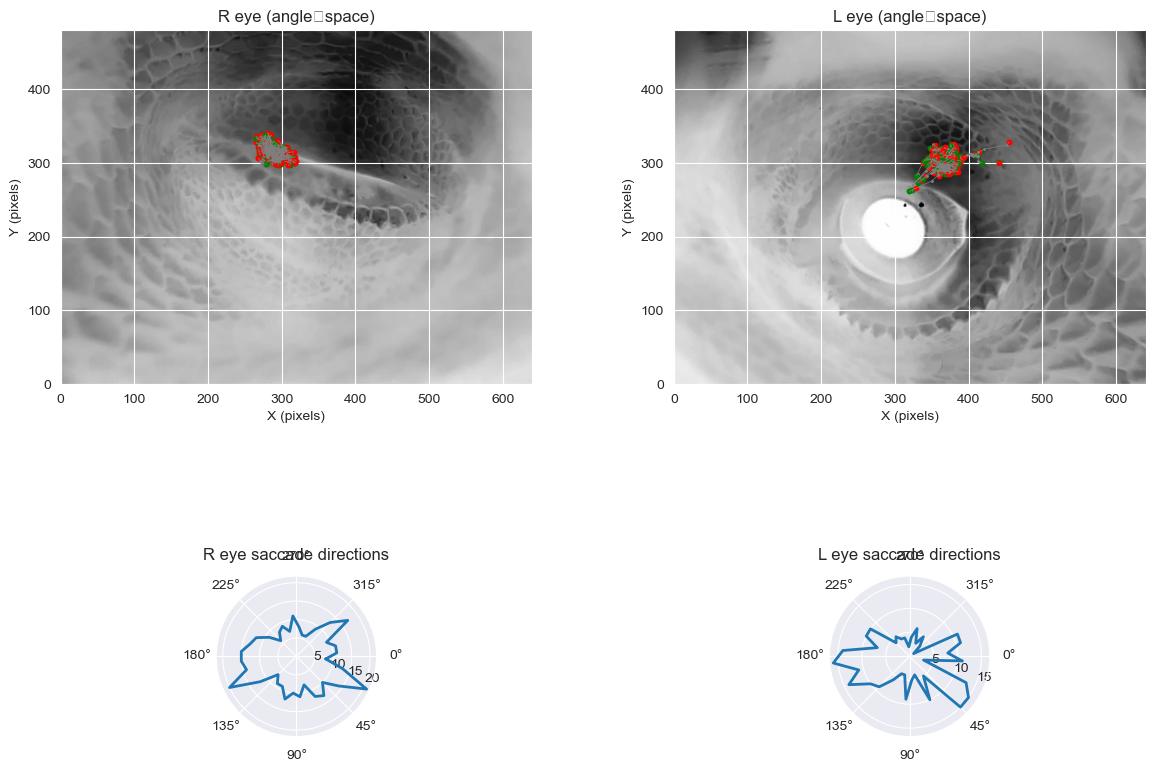

In [66]:
block = block_dict['PV_126_block_008']
block.load_best_reference(r'Z:\Nimrod\experiments\cross_animals_data\kerr_reference_all_animals_current_25_05_12.csv')
plot_block_angle_saccades_with_histogram(block,
                                         all_saccade_collection,
                                         nbins=36)